## EXPLORE Data Science Academy Classification Hackathon

### Honour Code

I {**YINKA, AKINDELE**}, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.


### Overview

South Africa is a multicultural society that is characterised by its rich linguistic diversity. Language is an indispensable tool that can be used to deepen democracy and also contribute to the social, cultural, intellectual, economic and political life of the South African society.

The country is multilingual with 11 official languages, each of which is guaranteed equal status. Most South Africans are multilingual and able to speak at least two or more of the official languages.

With such a multilingual population, it is only obvious that our systems and devices also communicate in multi-languages.

In this challenge, you will take text which is in any of South Africa's 11 Official languages and identify which language the text is in. This is an example of NLP's Language Identification, the task of determining the natural language that a piece of text is written in.


<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Logging to Comet</a>

<a href=#eight>8. Submission</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

In [1]:
# import comet_ml at the top of your file
from comet_ml import Experiment


In [2]:
# Create an experiment with your api key
experiment = Experiment(
    api_key="vYZLU5qF1hfDnC1UNRgZopRTg",
    project_name="hackathon-2022",
    workspace="yinka-akindele",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'C:\\Users\\yinka\\Desktop\\EXPLORE\\resources\\01. Technical\\06. Advanced Classification\\13. Advanced Classification Exam\\south-african-language-identification-hack-2022' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/yinka-akindele/hackathon-2022/ef5dcbc05ab84bbe8a188b4ba3019b67



In [3]:
# Libraries for data loading, data manipulation and data visulisation
import string
import numpy as np
import pandas as pd
import html
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
sns.set(font_scale=1.5)
style.use('seaborn-pastel')
style.use('seaborn-poster')
from PIL import Image
from wordcloud import WordCloud

# Some Conventional Libraries for Natrual Language processing
import re
import csv
import nltk
import pickle


# Libraries for data preparation and model building
# Preprocessing tools
from sklearn.preprocessing import LabelEncoder

#Basic sklearn tools
from sklearn.feature_extraction.text import CountVectorizer   
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Building classification models
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Libraries for Model evaluation
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [4]:
# load the data
train = pd.read_csv('resources/train_set.csv')

<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


In [5]:
# look at data statistics
train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


From the above observation, it can be seen that the train dataset does not contain any missing or null values.

In [7]:
train['lang_id'].value_counts()

xho    3000
eng    3000
nso    3000
ven    3000
tsn    3000
nbl    3000
zul    3000
ssw    3000
tso    3000
sot    3000
afr    3000
Name: lang_id, dtype: int64

By doing the value counts of the language id, it is obvious that the dataset is balanced and it therefore does not need resampling.


<AxesSubplot:>

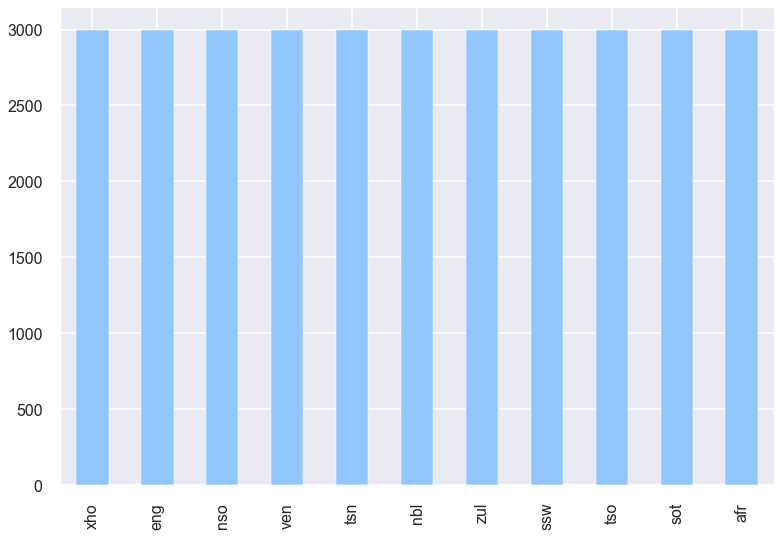

In [8]:
train['lang_id'].value_counts().plot(kind='bar')

<a id="four"></a>
## 4. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


In [9]:
# remove punctuations
#This block of code conducts further cleaning of the given dataset.
#Regex will employed for this task

for i in range (len(train['text'])):
    train['text'][i]=re.sub(r"(@[A-Za-z0-9_]+)|[^\w\s]|http\S+","",train['text'][i])
train.head()

,lang_id,text
0,xho,umgaqosiseko wenza amalungiselelo kumaziko axh...
1,xho,idha iya kuba nobulumko bokubeka umsebenzi nap...
2,eng,the province of kwazulunatal department of tra...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [10]:
lang_labels = list(train['lang_id'].unique())

<a id="five"></a>
## 5. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


In [11]:
# create targets and features dataset
X = train['text']   # features
y = train['lang_id']   # targets

In [12]:
# split data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.35, random_state=42)

## Create one or more ML models

### Pipelines

The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.

For this, it enables setting parameters of the various steps using their names and the parameter name 


### TfidfVectorizer

The TFIDF vectorizer assigns word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents.

The TfidfVectorizer will tokenize documents, learn the vocabulary and inverse document frequency weightings, and allow you to encode new documents.

Another advantage of this method is that the resulting vectors are already scaled.


##### Logistic Regression Model

In [13]:
logreg = Pipeline([('tfidf', TfidfVectorizer()),
                   ('clf', LogisticRegression(C=1, max_iter=100, multi_class='multinomial', class_weight='balanced'))])

##### Linear SVC

In [14]:
# Linear SVC:
lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                 ('clf', LinearSVC(max_iter=100,class_weight='balanced'))])


##### Naive Bayes

In [15]:
# Naïve Bayes:
nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB())])

##### Random Forest

In [16]:
# Random Forest Classifier
rf = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', RandomForestClassifier(max_depth=10, 
                                              n_estimators=1000, random_state=42))])


##### K Nearest Neighbour

In [19]:
# Random Forest Classifier
knn = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', KNeighborsClassifier(n_neighbors=5))])


##### Linear SVC Optimised by Tuning

In [20]:
lsvc_op = Pipeline([('tfidf', TfidfVectorizer(max_df=0.8, min_df=2, ngram_range=(1,2))),
                  ('clf', LinearSVC(C=0.3, class_weight='balanced', max_iter=100))])

## Training the models

##### Logistic Regression Model

In [21]:
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_valid)


##### Saving the Logistic regression model
lr_save_path = "resources/logistic_regression_model.pkl"
with open(lr_save_path,'wb') as lr_file:
    pickle.dump(logreg, lr_file)


C:\Users\yinka\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##### Linear SVC

In [22]:
##### Linear SVC
lsvc.fit(X_train, y_train)
y_pred_lsvc = lsvc.predict(X_valid)


##### Saving the Linear SVC model
lsvc_save_path = "resources/linear_svc_model.pkl"
with open(lsvc_save_path,'wb') as lsvc_file:
    pickle.dump(lsvc, lsvc_file)


##### Naive Bayes

In [23]:
##### Naive bayes
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_valid)


##### Saving the Naive Bayes model
nb_save_path = "resources/naive_bayes_model.pkl"
with open(nb_save_path,'wb') as nb_file:
    pickle.dump(nb, nb_file)


##### Random Forest Model

In [24]:
###### Random forest 
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_valid)


##### Saving the Random Forest model
rf_save_path = "resources/random_forest_model.pkl"
with open(rf_save_path,'wb') as rf_file:
    pickle.dump(rf, rf_file)


COMET ERROR: Failed to extract parameters from estimator


##### K Nearest Neighbour

In [25]:
##### Fit and predict
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_valid)

##### Saving the K Nearest Neighbour model
knn_save_path = "resources/lsvc_op_model.pkl"
with open(knn_save_path,'wb') as knn_file:
    pickle.dump(knn, knn_file)

##### Linear SVC Optimised by Tuning

In [26]:
##### Fit and predict
lsvc_op.fit(X_train, y_train)
y_pred = lsvc_op.predict(X_valid)

##### Saving the K Nearest Neighbour model
lsvc_op_save_path = "resources/lsvc_op_model.pkl"
with open(lsvc_op_save_path,'wb') as lsvc_op_file:
    pickle.dump(lsvc_op, lsvc_op_file)

<a id="six"></a>
## 6. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


##### Logistic Regression Model

In [27]:
# Model performance
f1 = f1_score(y_valid, y_pred_logreg, average='weighted')
precision = precision_score(y_valid, y_pred_logreg, average='weighted')
recall = recall_score(y_valid, y_pred_logreg, average='weighted')


print("f1 = ", f1)
print("recall = ", recall)
print("precision = ", precision)
print("\n\n\n\nClassification Report")
print(classification_report(y_valid, y_pred_logreg))

f1 =  0.99463257895802
recall =  0.9946320346320346
precision =  0.9946444822266561




Classification Report
              precision    recall  f1-score   support

         afr       1.00      0.99      1.00      1040
         eng       1.00      1.00      1.00      1053
         nbl       0.99      0.98      0.99      1020
         nso       1.00      1.00      1.00      1087
         sot       1.00      1.00      1.00      1079
         ssw       0.99      0.99      0.99      1058
         tsn       1.00      1.00      1.00      1043
         tso       1.00      1.00      1.00      1014
         ven       1.00      1.00      1.00      1089
         xho       0.99      1.00      0.99      1065
         zul       0.98      0.98      0.98      1002

    accuracy                           0.99     11550
   macro avg       0.99      0.99      0.99     11550
weighted avg       0.99      0.99      0.99     11550



##### Linear SVC

In [28]:
# Model performance
f1 = f1_score(y_valid, y_pred_lsvc, average='weighted')
precision = precision_score(y_valid, y_pred_lsvc, average='weighted')
recall = recall_score(y_valid, y_pred_lsvc, average='weighted')


print("f1 = ", f1)
print("recall = ", recall)
print("precision = ", precision)
print("\n\n\n\nClassification Report")
print(classification_report(y_valid, y_pred_lsvc))

f1 =  0.9974890202821773
recall =  0.9974891774891775
precision =  0.99749227581991




Classification Report
              precision    recall  f1-score   support

         afr       1.00      1.00      1.00      1040
         eng       1.00      1.00      1.00      1053
         nbl       1.00      0.99      0.99      1020
         nso       1.00      1.00      1.00      1087
         sot       1.00      1.00      1.00      1079
         ssw       1.00      1.00      1.00      1058
         tsn       1.00      1.00      1.00      1043
         tso       1.00      1.00      1.00      1014
         ven       1.00      1.00      1.00      1089
         xho       0.99      1.00      0.99      1065
         zul       0.99      0.99      0.99      1002

    accuracy                           1.00     11550
   macro avg       1.00      1.00      1.00     11550
weighted avg       1.00      1.00      1.00     11550



##### Naive Bayes

In [29]:
# Model performance
f1 = f1_score(y_valid, y_pred_nb, average='weighted')
precision = precision_score(y_valid, y_pred_nb, average='weighted')
recall = recall_score(y_valid, y_pred_nb, average='weighted')


print("f1 = ", f1)
print("recall = ", recall)
print("precision = ", precision)
print("\n\n\n\nClassification Report")
print(classification_report(y_valid, y_pred_nb))

f1 =  0.9987877843142168
recall =  0.9987878787878788
precision =  0.9987896279854529




Classification Report
              precision    recall  f1-score   support

         afr       1.00      1.00      1.00      1040
         eng       1.00      1.00      1.00      1053
         nbl       0.99      1.00      1.00      1020
         nso       1.00      1.00      1.00      1087
         sot       1.00      1.00      1.00      1079
         ssw       1.00      1.00      1.00      1058
         tsn       1.00      1.00      1.00      1043
         tso       1.00      1.00      1.00      1014
         ven       1.00      1.00      1.00      1089
         xho       1.00      1.00      1.00      1065
         zul       1.00      0.99      1.00      1002

    accuracy                           1.00     11550
   macro avg       1.00      1.00      1.00     11550
weighted avg       1.00      1.00      1.00     11550



##### Random Forest Model

In [30]:
# Model performance
f1 = f1_score(y_valid, y_pred_rf, average='weighted')
precision = precision_score(y_valid, y_pred_rf, average='weighted')
recall = recall_score(y_valid, y_pred_rf, average='weighted')


print("f1 = ", f1)
print("recall = ", recall)
print("precision = ", precision)
print("\n\n\n\nClassification Report")
print(classification_report(y_valid, y_pred_rf))

f1 =  0.955465418132662
recall =  0.954025974025974
precision =  0.9629176300331089




Classification Report
              precision    recall  f1-score   support

         afr       1.00      1.00      1.00      1040
         eng       0.99      1.00      0.99      1053
         nbl       0.94      0.90      0.92      1020
         nso       1.00      0.99      1.00      1087
         sot       1.00      1.00      1.00      1079
         ssw       1.00      0.82      0.90      1058
         tsn       0.99      1.00      1.00      1043
         tso       1.00      1.00      1.00      1014
         ven       1.00      1.00      1.00      1089
         xho       0.97      0.84      0.90      1065
         zul       0.70      0.95      0.81      1002

    accuracy                           0.95     11550
   macro avg       0.96      0.95      0.95     11550
weighted avg       0.96      0.95      0.96     11550



##### K Nearest Neighbour

In [31]:
# Model performance
f1 = f1_score(y_valid, y_pred_knn, average='weighted')
precision = precision_score(y_valid, y_pred_knn, average='weighted')
recall = recall_score(y_valid, y_pred_knn, average='weighted')


print("f1 = ", f1)
print("recall = ", recall)
print("precision = ", precision)
print("\n\n\n\nClassification Report")
print(classification_report(y_valid, y_pred_knn))

f1 =  0.9641164297305882
recall =  0.9643290043290044
precision =  0.9647556488688038




Classification Report
              precision    recall  f1-score   support

         afr       0.99      0.99      0.99      1040
         eng       0.98      1.00      0.99      1053
         nbl       0.89      0.96      0.92      1020
         nso       0.95      0.97      0.96      1087
         sot       0.98      0.98      0.98      1079
         ssw       0.97      0.97      0.97      1058
         tsn       0.96      0.94      0.95      1043
         tso       0.98      1.00      0.99      1014
         ven       1.00      1.00      1.00      1089
         xho       0.96      0.93      0.94      1065
         zul       0.96      0.86      0.90      1002

    accuracy                           0.96     11550
   macro avg       0.96      0.96      0.96     11550
weighted avg       0.96      0.96      0.96     11550



##### Optimised model by Tuning

In [32]:
# Model performance
f1 = f1_score(y_valid, y_pred, average='weighted')
precision = precision_score(y_valid, y_pred, average='weighted')
recall = recall_score(y_valid, y_pred, average='weighted')


print("f1 = ", f1)
print("recall = ", recall)
print("precision = ", precision)
print("\n\n\n\nClassification Report")
print(classification_report(y_valid, y_pred))

f1 =  0.9972289531813664
recall =  0.9972294372294372
precision =  0.9972324536215577




Classification Report
              precision    recall  f1-score   support

         afr       1.00      1.00      1.00      1040
         eng       1.00      1.00      1.00      1053
         nbl       1.00      0.99      0.99      1020
         nso       1.00      1.00      1.00      1087
         sot       1.00      1.00      1.00      1079
         ssw       1.00      1.00      1.00      1058
         tsn       1.00      1.00      1.00      1043
         tso       1.00      1.00      1.00      1014
         ven       1.00      1.00      1.00      1089
         xho       0.99      1.00      0.99      1065
         zul       0.99      0.99      0.99      1002

    accuracy                           1.00     11550
   macro avg       1.00      1.00      1.00     11550
weighted avg       1.00      1.00      1.00     11550



 <a id="seven"></a>
## 7. Logging to Comet.
<a href=#cont>Back to Table of Contents</a>


In [33]:
# Create dictionaries for the data we want to log

params = {"random_state": 42,
          "model_type": "lsvc_op",
          "max_df": 0.8,
          "min_df": 2,
          "ngram_range": (1, 3),
          "C": 0.3,
           "class_weight": "balanced",
          "max_iter": 10000
          }

metrics = {"f1": f1,
           "recall": recall,
           "precision": precision
           }

In [34]:
# Log our parameters and results
experiment.log_parameters(params)
experiment.log_metrics(metrics)

In [35]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/yinka-akindele/hackathon-2022/ef5dcbc05ab84bbe8a188b4ba3019b67
COMET INFO:   Metrics:
COMET INFO:     f1        : 0.9972289531813664
COMET INFO:     precision : 0.9972324536215577
COMET INFO:     recall    : 0.9972294372294372
COMET INFO:   Parameters:
COMET INFO:     C                             : 0.3
COMET INFO:     algorithm                     : auto
COMET INFO:     alpha                         : 1.0
COMET INFO:     bootstrap                     : True
COMET INFO:     ccp_alpha                     : 0.0
COMET INFO:     class_prior                   : 1
COMET INFO:     class_weight                  : balanced
COMET INFO:     clf                           : LinearSVC(C=0.3, class_weight='balanced', max_iter=100)
COMET INFO:     clf_C          

COMET INFO:     tfidf__strip_accents          : 1
COMET INFO:     tfidf__sublinear_tf           : False
COMET INFO:     tfidf__token_pattern          : (?u)\b\w\w+\b
COMET INFO:     tfidf__tokenizer              : 1
COMET INFO:     tfidf__use_idf                : True
COMET INFO:     tfidf__vocabulary             : 1
COMET INFO:     tfidf_analyzer                : word
COMET INFO:     tfidf_binary                  : False
COMET INFO:     tfidf_decode_error            : strict
COMET INFO:     tfidf_dtype                   : <class 'numpy.float64'>
COMET INFO:     tfidf_encoding                : utf-8
COMET INFO:     tfidf_input                   : content
COMET INFO:     tfidf_lowercase               : True
COMET INFO:     tfidf_max_df                  : 0.8
COMET INFO:     tfidf_max_features            : 1
COMET INFO:     tfidf_min_df                  : 2
COMET INFO:     tfidf_ngram_range             : (1, 2)
COMET INFO:     tfidf_norm                    : l2
COMET INFO:     tfidf_prep

 <a id="eight"></a>
## 8. Submission
<a href=#cont>Back to Table of Contents</a>


In [36]:
test = pd.read_csv('resources/test_set.csv')


for i in range (len(test['text'])):
    test['text'][i] = re.sub(r"(@[A-Za-z0-9_]+)|[^\w\s]|http\S+","",test['text'][i])

test_pred = nb.predict(test['text'])

output = pd.DataFrame({'index': test['index'],
                       'lang_id': test_pred})

output.to_csv('resources/nb_submission.csv', index=False)

output

C:\Users\yinka\AppData\Local\Temp\ipykernel_19368\4152600230.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['text'][i] = re.sub(r"(@[A-Za-z0-9_]+)|[^\w\s]|http\S+","",test['text'][i])


,index,lang_id
0,1,tsn
1,2,nbl
2,3,ven
3,4,ssw
4,5,afr
...,...,...
5677,5678,eng
5678,5679,nso
5679,5680,sot
5680,5681,sot
